# Integrating PPI data to identify OPC-endothelial cell interactors

In [1]:
import urllib
import os

import pandas
import numpy
import networkx

%matplotlib inline

In [2]:
url_to_path = {
    # STRING PPI
    'http://string.embl.de/newstring_download/protein.aliases.v10/10090.protein.aliases.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz'),
    'http://string.embl.de/newstring_download/protein.links.v10/10090.protein.links.v10.txt.gz':
        os.path.join('download', 'string', '10090.protein.links.v10.txt.gz'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

## Read and prepare STRING

In [3]:
path = os.path.join('download', 'string', '10090.protein.aliases.v10.txt.gz')
alias_df = pandas.read_table(path, skiprows=1, names = ['string_protein_id', 'alias', 'source'])

In [4]:
alias_df = alias_df.query("source == 'BLAST_KEGG_NAME BLAST_UniProt_GN Ensembl_EntrezGene Ensembl_IKMCs_ES_cells_available Ensembl_MGI Ensembl_UniProt_GN Ensembl_WikiGene'")
alias_df = alias_df[['string_protein_id', 'alias']]

In [5]:
path = os.path.join('download', 'string', '10090.protein.links.v10.txt.gz')
string_df = pandas.read_table(path, sep=' ')

In [6]:
string_df = string_df.merge(
    alias_df.rename(columns={'string_protein_id': 'protein1', 'alias': 'name_a'})).merge(
    alias_df.rename(columns={'string_protein_id': 'protein2', 'alias': 'name_b'}))

string_df = string_df[['name_a', 'name_b', 'combined_score']].drop_duplicates()
string_df = string_df.sort_values(['name_a', 'name_b'])
string_df.head(2)

,name_a,name_b,combined_score
3478100,0610007P14Rik,2610028H24Rik,648
3849791,0610007P14Rik,Aacs,153


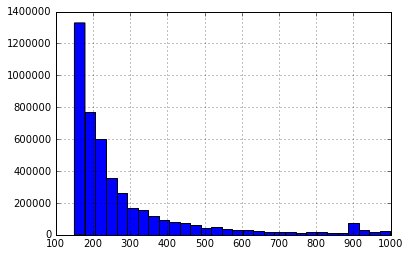

In [7]:
string_df.combined_score.hist(bins=30);

## Integrate expression and GO data

In [8]:
# Parameters
fc_cutoff = 1.5
string_score = 700
go_names = [
    'cell surface',
    'cell-cell adhesion'
]

param_df = pandas.DataFrame({'parameter': ['fold_change_cutoff', 'string_score_cutoff', 'GO_terms'],
                             'value': [fc_cutoff, string_score, go_names]})

In [9]:
fc_df = pandas.read_table('data/enrichment.tsv')
fc_df.head(2)

,Gene symbol,Description,Astrocytes,Neuron,Oligodendrocyte Precursor Cell,Newly Formed Oligodendrocyte,Myelinating Oligodendrocytes,Microglia,Endothelial Cells,cell-cell adhesion,cell surface,opc_fold_change,endothelial_fold_change,DA_Cat_fold_change
0,0610005C13Rik,NaN,0.15096,0.100,0.100,0.100,0.100,0.100,0.100,0,0,0.00000,-0.11760,NaN
1,0610007C21Rik,NaN,44.89100,34.185,71.221,57.986,54.006,89.145,63.561,0,0,0.39919,0.11792,NaN


In [10]:
# Filter genes by expression and GO membership
fc_df = fc_df.query("opc_fold_change >= @fc_cutoff or endothelial_fold_change >= @fc_cutoff")
for go_name in go_names:
    fc_df = fc_df[fc_df[go_name] == 1]
    
len(fc_df)

88

In [11]:
get_renamer = lambda x: {
    'Gene symbol': 'name_' + x,
    'opc_fold_change': 'opc_fc_' + x,
    'endothelial_fold_change': 'endo_fc_' + x,
    'DA_Cat_fold_change': 'dac_fc_' + x,
}

fc_df = fc_df[['Gene symbol', 'opc_fold_change', 'endothelial_fold_change', 'DA_Cat_fold_change']]
ixn_df = string_df.merge(
    fc_df.rename(columns=get_renamer('a'))).merge(
    fc_df.rename(columns=get_renamer('b')))

In [12]:
ixn_df.head(2)

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,dac_fc_a,opc_fc_b,endo_fc_b,dac_fc_b
0,Alcam,B2m,191,5.5683,-3.5519,NaN,2.7299,1.6164,NaN
1,Ccr7,B2m,377,2.1161,-3.9460,NaN,2.7299,1.6164,NaN


In [13]:
len(ixn_df)

918

## Filter for candidate interactions

In [14]:
filtered_df = ixn_df.query(
    "combined_score >= @string_score and ((opc_fc_a >= @fc_cutoff and endo_fc_b >= @fc_cutoff) or (opc_fc_b >= @fc_cutoff and endo_fc_a >= @fc_cutoff))"
)

filtered_df = filtered_df.sort_values(['name_a', 'name_b'])

# Number of interactions
len(filtered_df)

100

In [15]:
filtered_df.head(2)

,name_a,name_b,combined_score,opc_fc_a,endo_fc_a,dac_fc_a,opc_fc_b,endo_fc_b,dac_fc_b
326,Alcam,Itgb1,858,5.5683,-3.5519,NaN,1.0750,2.3607,NaN
29,Anxa1,Ccr7,900,2.6875,5.4665,NaN,2.1161,-3.9460,NaN


In [16]:
count_df = pandas.concat([filtered_df.name_a, filtered_df.name_b]).value_counts().reset_index()
count_df.columns = ['gene', 'interactions']
count_df.head(4)

,gene,interactions
0,Itgb1,22
1,Il6,18
2,Itga4,16
3,Icam1,14


In [17]:
# Genes with interactions
genes = set(count_df.gene)
len(genes)

28

In [18]:
# Save to excel
path = os.path.join('data', 'filtered.xlsx')
writer = pandas.ExcelWriter(path)
filtered_df.to_excel(writer, index=False, sheet_name='interactions')
count_df.to_excel(writer, index=False, sheet_name='gene_counts')
param_df.to_excel(writer, index=False, sheet_name='parameters')
writer.close()

## Network

In [22]:
graph = networkx.Graph()
for i, row in fc_df.iterrows():
    gene = row['Gene symbol']
    if not gene in genes:
        continue
    graph.add_node(gene,
                   opc_fc = row['opc_fold_change'],
                   endo_fc = row['endothelial_fold_change'],
                   dac_fc = row['DA_Cat_fold_change'])
for i, row in filtered_df.iterrows():
    graph.add_edge(row.name_a, row.name_b, weight=row.combined_score)

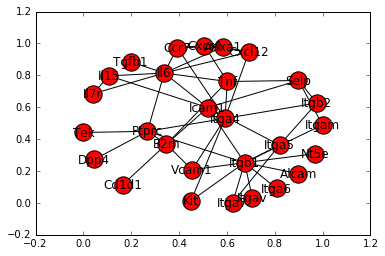

In [23]:
pos = networkx.spring_layout(graph, weight='weight', iterations=500, k=2)
pc = networkx.draw_networkx_nodes(graph, pos)
pc = networkx.draw_networkx_edges(graph, pos)
labels = networkx.draw_networkx_labels(graph, pos)

In [24]:
# Save network
path = os.path.join('data', 'network.graphml')
networkx.readwrite.write_graphml(graph, path)